# Проект "Мастерская 1" : Стартапы

Предоставлены данные о стартапах, функционировавших в период с 1970 по 2018 годы. Необходимо на основе представленных данных сделать предсказание закроется ли стартап.

Задачи данной работы:
1. Проанализировать данные;
2. Построить модель для предсказания

Данные представлены в двух файлах:
1. тестовые входные признаки;
2. Файл с обучающими признаками.

In [1]:
#установка библиотек

!pip install phik
!pip install scikit-learn==1.4.2
!pip install shap 
!pip install imbalanced-learn
!pip install seaborn
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [239]:
#проверка версии sklearn (важно для дальнейшего использования при обучении модели)
import sklearn
sklearn.__version__

'1.4.2'

In [240]:
# версия numpy 2.00 позднее пока не совместимы с библиотекой catboost? поэтому установим подходящую версию.
!pip install numpy==1.26.4

In [9]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
###загрузка библиотек и констант

import numpy as np
import pandas as pd

# загрузка для визуализации графиков
import matplotlib.pyplot as plt 
import seaborn as sns

# загрузка класса pipeline
from sklearn.pipeline import Pipeline

# загрука класса для подготовки данных
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.compose import ColumnTransformer

# загрузка класса для работы с пропусками
from sklearn.impute import SimpleImputer

# загрузка функции для работы с метриками
from sklearn.metrics import f1_score

# загрузка нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# импорт классов для поиска гипперпараметров
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTENC

# загрузка инструментов для корреляционного анализа
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

#оценка важности признаков
import shap

#фиксация времени
import time


from catboost import CatBoostClassifier

In [15]:
#константы
RANDOM_STATE = 42ф

### Загрузка файлов

Создадим функцию для загрузки исходных данных и их первичного анализа.


In [16]:
#функция для загрузки и ознакомления с данными
def introduce(path_file, parse_dates, sep=',', decimal='.'): 
    data = pd.read_csv(path_file, sep = sep, decimal = decimal, parse_dates = parse_dates)
    display(data.describe(), data.info())
    return data

In [17]:
#загрузим тестовые данные
test_data = introduce('kaggle_startups_test_28062024.csv', ['first_funding_at', 'last_funding_at' ])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


funding_total_usd  funding_rounds            first_funding_at  \
count       1.054700e+04    13125.000000                       13125   
mean        1.654910e+07        1.714438  2011-07-23 20:54:08.640000   
min         1.000000e+00        1.000000         1973-04-15 00:00:00   
25%         3.200000e+05        1.000000         2009-11-16 00:00:00   
50%         2.000000e+06        1.000000         2012-08-01 00:00:00   
75%         1.000000e+07        2.000000         2014-04-01 00:00:00   
max         4.715000e+09       15.000000         2015-12-03 00:00:00   
std         9.217283e+07        1.318800                         NaN   

                     last_funding_at      lifetime  
count                          13125  13125.000000  
mean   2012-06-16 05:03:41.348571392   3097.609524  
min              1973-04-15 00:00:00     52.000000  
25%              2011-01-10 00:00:00   1726.000000  
50%              2013-08-21 00:00:00   2526.000000  
75%              2014-11-11 00:00:00   3866.000000  
max              2015-12-12 00:00:00  17167.000000  
std                              NaN   2128.356554

None

**Вывод:**
1. По кататегориальным столбцам присутствуют пропуски;
2. Количественные данные без пропусков, может пригодиться масштабировани, т.к. порядок значений сильно отличается.

In [18]:
#загрузка тренировочнеых данных
train_data = introduce('kaggle_startups_train_28062024.csv', ['founded_at', 'closed_at','first_funding_at', 'last_funding_at' ])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

funding_total_usd  funding_rounds                     founded_at  \
count       4.244700e+04    52516.000000                          52516   
mean        1.824748e+07        1.740670  2008-11-04 09:44:16.196206848   
min         1.000000e+00        1.000000            1970-02-05 00:00:00   
25%         3.360275e+05        1.000000            2006-10-01 00:00:00   
50%         2.000000e+06        1.000000            2010-10-01 00:00:00   
75%         1.000000e+07        2.000000            2013-01-01 00:00:00   
max         3.007950e+10       19.000000            2016-04-02 00:00:00   
std         1.871173e+08        1.374522                            NaN   

                    first_funding_at                last_funding_at  \
count                          52516                          52516   
mean   2011-07-17 04:45:33.247010304  2012-06-27 16:29:42.313961472   
min              1977-05-15 00:00:00            1977-05-15 00:00:00   
25%              2009-10-12 00:00:00            2011-02-01 00:00:00   
50%              2012-07-23 00:00:00            2013-08-30 00:00:00   
75%              2014-04-01 00:00:00            2014-11-17 00:00:00   
max              2015-12-05 00:00:00            2015-12-07 00:00:00   
std                              NaN                            NaN   

                           closed_at  
count                           4917  
mean   2012-01-16 16:14:21.012812544  
min              1983-10-06 00:00:00  
25%              2009-09-18 00:00:00  
50%              2012-09-15 00:00:00  
75%              2015-04-23 00:00:00  
max              2017-10-21 00:00:00  
std                              NaN

None

**Вывод**:
1. В тестовых и тренировочных данных имеются пропуски.  В процессе предобработки постараемся их заполнить;
2. Неисключены выбросы т.к. максимум и минимумы отличаются значительно, также среднее и медиана отличаются;
3. в тренировочных данных нет признака `lifetime`. Образуем его из признаков `founded_at` и `closed_at`,  которые отсутствуют в целевой выборке. 

### Предобработка данных

In [19]:
#проверка на пполные дубликаты
train_data.duplicated(subset=['name', 'country_code',
       'state_code', 'region', 'city', 'founded_at']).sum()

0

**Вывод**: Полных дубликатов строк - нет

In [20]:
#количество пропусков по столбца тренировочной выборки
train_data.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

**Вывод:** пропуски в числовых данны, датах, "статусах" отсутствуют. Категорильные  номинальные, поэтому можно заполнить  значением  `unknown`

Признак `name` не должнен влиять на целевой, т.к. содержит множество уникальных значений., поэтому его можно удалять 

In [21]:
# целевой признак
train_data['status'].value_counts()

status
operating    47599
closed        4917
Name: count, dtype: int64

**Вывод**: В тренировочных данных явный дисбаланс данных, для корректного обучения модели применим метод сэмлинга перед обучением.

In [22]:
(train_data['closed_at'].isna()).sum()

47599

Наличие дат закрытие проекта совпадает с количеством статусов закрытия. что является утечкой данных. Исключим этот признак в дальнейшем

Пропуски стран, городов, штатов тоже нельзя присвоить. либо присвоить `unknouwn`

In [23]:
train_data.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at'],
      dtype='object')

In [24]:
# заполнение пропусков категориальных данных
train_data[['name', 'category_list','country_code',
            'state_code', 'region', 'city']] = train_data[['name', 'category_list','country_code',
                                                           'state_code', 'region', 'city']].fillna('unknown')

In [25]:
# заполнение количественных данных оставим как есть, т.к. отсутствие данных не противоречит тому что "статусу". А нули противоречат тому что стартап существовал.
#train_data['funding_total_usd'] = train_data['funding_total_usd'].fillna(0)

In [26]:
#проверка заполнения пропусков
train_data.isna().sum()

name                     0
category_list            0
funding_total_usd    10069
status                   0
country_code             0
state_code               0
region                   0
city                     0
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

In [27]:
import datetime
#import math # math.isnan занимает меньше RAM, чем np.isnan

In [28]:
train_data.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at'],
      dtype='object')

In [29]:
train_data['lifetime'] = pd.DataFrame(np.where(train_data['closed_at'].isna(), (datetime.datetime(2018, 1, 1) - train_data['founded_at']).dt.days, (train_data['closed_at'] - train_data['founded_at']).dt.days))
#train_data.apply(lambda x: (datetime.datetime(2018, 1, 1) - x['founded_at']).days if m(x['closed_at']) else (x['closed_at'] - x['founded_at']).days, axis=1)# if x['closed_at'] == 'NaN' else (x['closed_at'] - x['founded_at']).days, axis=1)
#(datetime.datetime(2018, 1, 1) - train_data['founded_at']).dt.days #if train_data['closed_at'].isna() else (train_data['closed_at'] - train_data['founded_at']).dt.days
#pd.DataFrame(np.where(train_data['closed_at'].isna(), (datetime.datetime(2018, 1, 1) - train_data['founded_at']).dt.days, (train_data['closed_at'] - train_data['founded_at']).dt.days))

In [30]:
train_data = train_data.drop(['founded_at','closed_at'], axis=1)

In [31]:
# создадим признак `time_bwn_funding` о разнице во времени между первей и последней инвестицией в стартап.
train_data['time_bwn_funding'] = (train_data['last_funding_at'] - train_data['first_funding_at']).dt.days

In [2]:
train_data['country_code'].value_counts()

NameError: name 'train_data' is not defined

In [36]:
## добавим новый признак на основе кодов стран, который покажет принадлежность континентам.
# загрузим справочник
continent = pd.read_csv('country_continent.csv',sep=';')
# добавим новый признак в отдельный столбец
train_data = train_data.merge(continent, how='left', on='country_code')

In [39]:
# заполним пустые значения после объединения таблиц признаком 'unknown'
train_data.loc[train_data['continent'].isna(), 'continent'] = 'unknown'

In [40]:
#проверим на пропуски данные
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   first_funding_at   52516 non-null  datetime64[ns]
 10  last_funding_at    52516 non-null  datetime64[ns]
 11  lifetime           52516 non-null  float64       
 12  time_bwn_funding   52516 non-null  int64         
 13  continent          52516 non-null  object        
dtypes: dat

**Промежуточный вывод:**
1. Явные дубликаты не были выявлены;
2. Пропуски в текстовых столбцах их заполнили `Unknown`;
3. Получили столбец `lifetime` обучающей выборки, как в тестовой выборке
4. Исключили столбцы `founded_at`, `closed_at`,  т.к. этих признаков нет в тестовой выборке;
5. создали признак `time_bwn_funding` о разнице во времени между первей и последней инвестицией в стартап;
6. добавили новый признак "континенты".

### Количественные данные

#### Анализ данных

In [41]:
## Функция построения графиков для анализа количественных данных
def stat_chart(data, col_name, title, xlabel_name, hue=None, log_scale=False):
    fig, axs = plt.subplots(2, 1,  figsize=(15,9))
    fig.suptitle(title)
    # простроение гистограммы на данных
    sns.histplot(data, x=col_name, bins=50, ax=axs[0], hue=hue, log_scale=log_scale)
    axs[0].set_xlabel(xlabel_name)
    axs[0].set_ylabel('Частота')
    axs[0].grid()
    # простроение ящика с усами на данных
    sns.boxplot(data=data, x=col_name, y=hue,  ax=axs[1], orient='h', log_scale=log_scale)
    axs[1].set_xlabel(xlabel_name)
    axs[1].set_ylabel('Категория')

    plt.show()

In [42]:
train_data = train_data.replace([np.inf, -np.inf], np.nan)

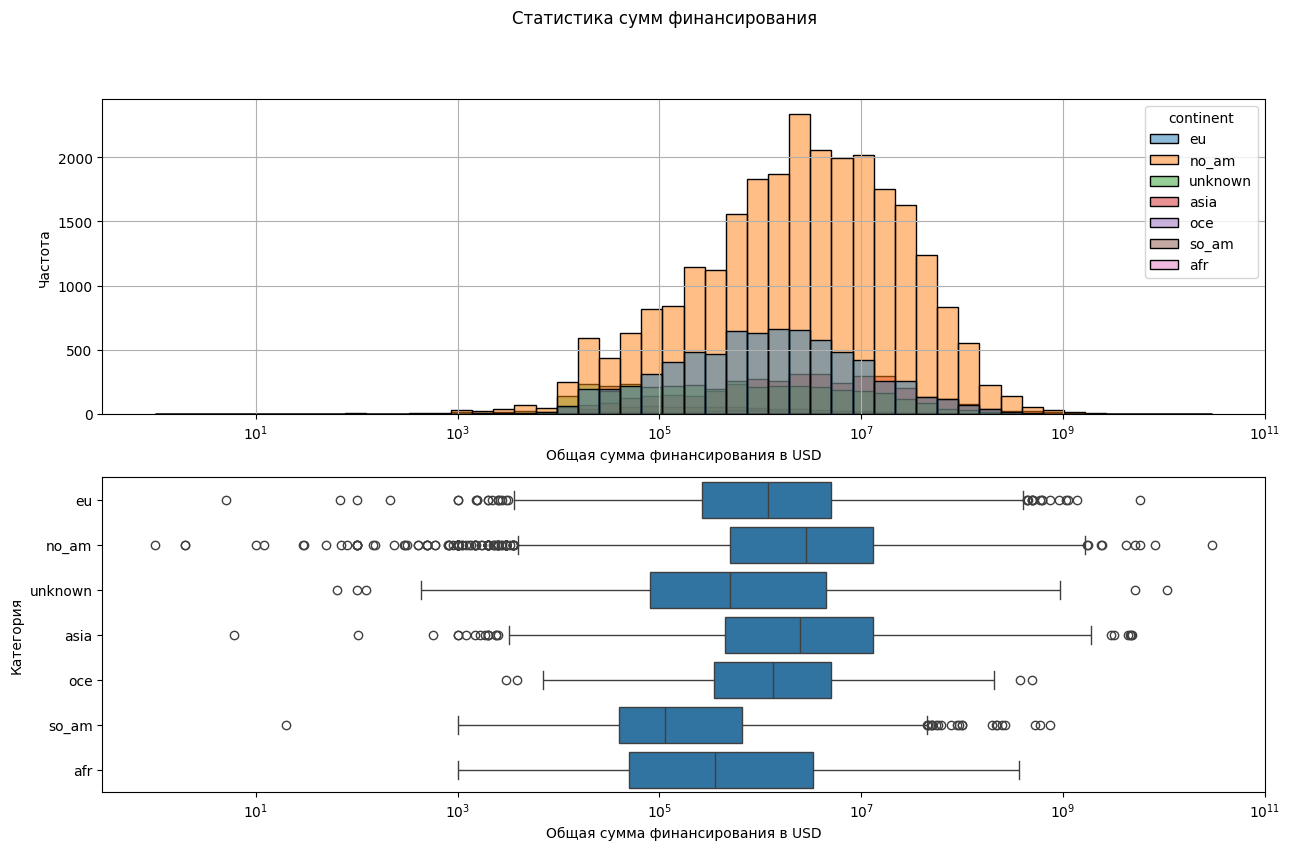

In [43]:
# Построение графиков для анализа данных об общей сумме финансирования
stat_chart(train_data,
            'funding_total_usd',
            'Статистика сумм финансирования',
            'Общая сумма финансирования в USD', log_scale=True,  hue='continent')

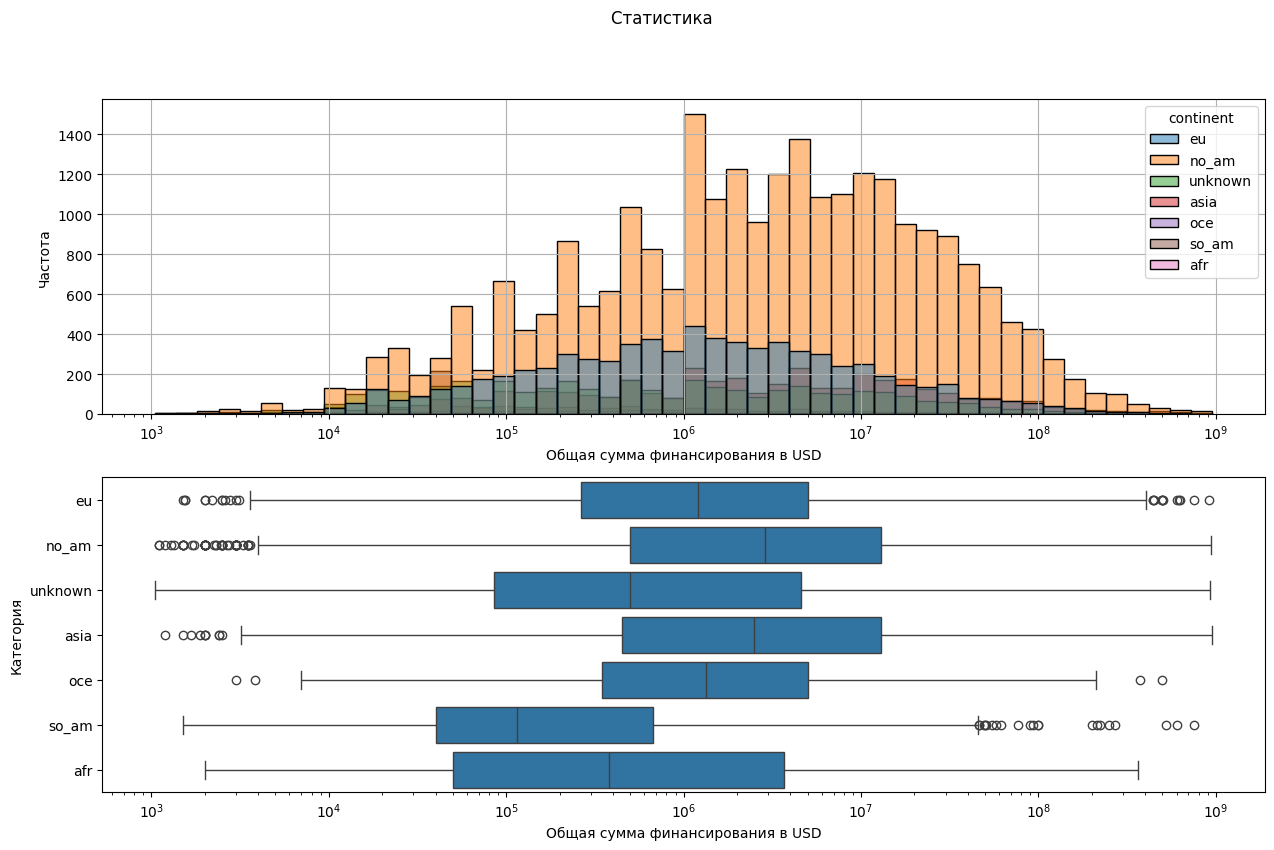

In [44]:
#сделаем усеченное распределение.
train_data = train_data.query('1000 < funding_total_usd < 1000000000')
stat_chart(train_data,
            'funding_total_usd',
           'Статистика ',
           'Общая сумма финансирования в USD', log_scale=True, hue='continent')

**Вывод:**
1. По форме раcпределение похоже на лог нормальное;
2. Присутствуют выбросы, можно применить усеченное распределение.

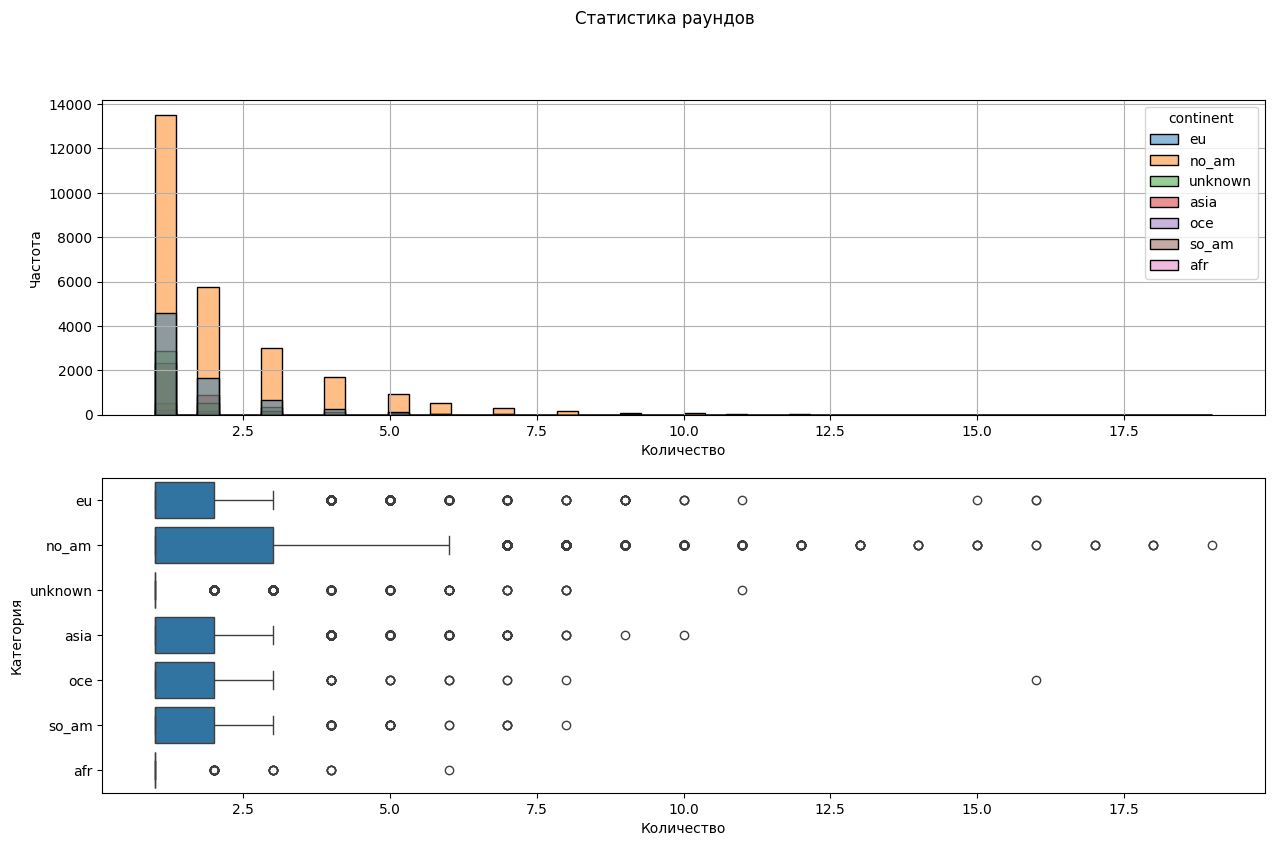

In [45]:
#данные о проведенных раундах
stat_chart(train_data,
            'funding_rounds',
            'Статистика раундов',
            'Количество', hue='continent')

**Вывод:** 
1. Распределение  Пуассона;
2. Возможно имеет смысл разобраться с выбросами

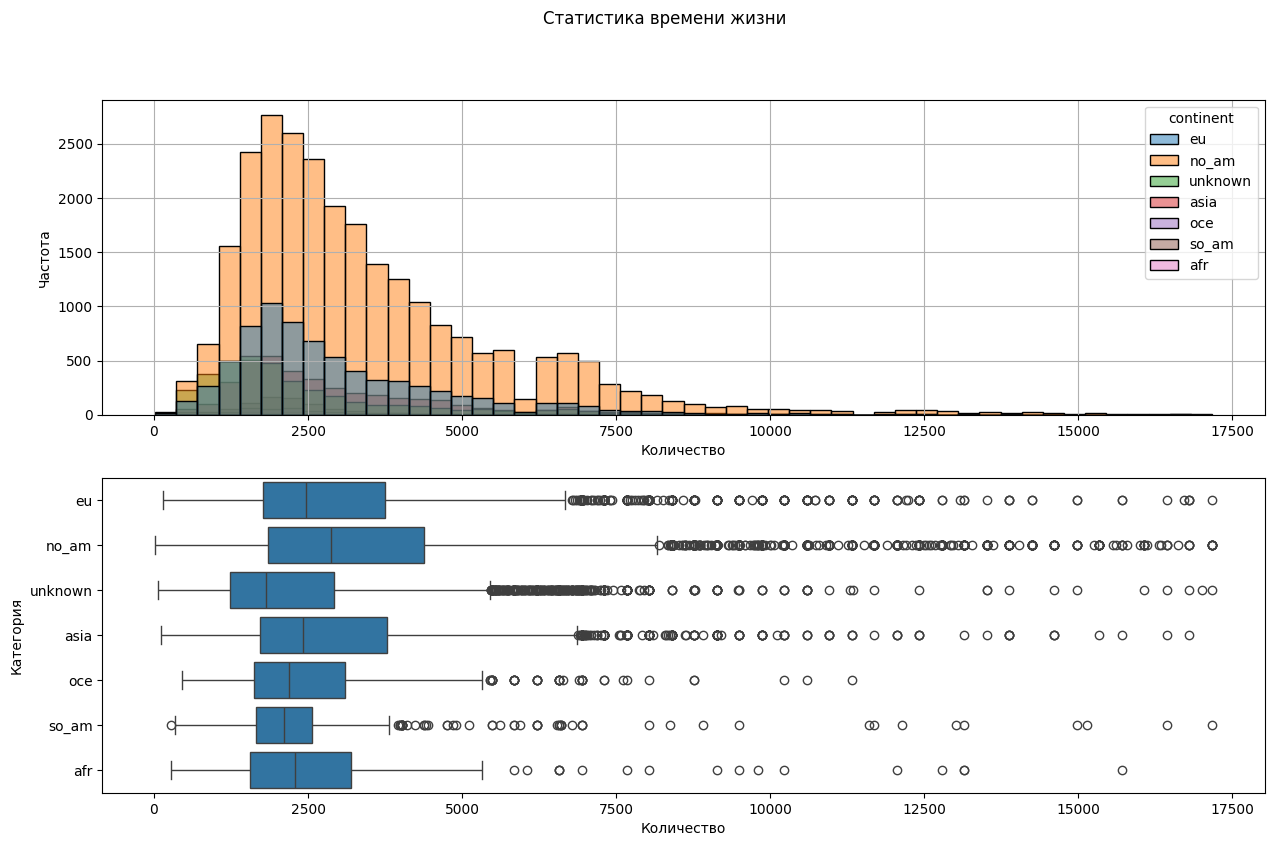

In [46]:
# данные о времени жизни проекта
stat_chart(train_data,
            'lifetime',
            'Статистика времени жизни',
            'Количество дней', hue='continent')

**Вывод:**
1. Распределение признака одномодальное, несимметричное;
2. Медиана смещена влево;
3. Выбросы присутсвуют, но пока не будем от них избавляться

In [7]:
## чтобы уйти от  работы с датами на прямую, будем использовать года и месяцы. Для этого создадим функцию
#функция разделения дат на месяцы и годы
def split_date(df, *cols):
    for col in cols:
        df[col + '_year'] = pd.DatetimeIndex(df[col]).year
        df[col + '_month'] = pd.DatetimeIndex(df[col]).month
    return df

In [49]:
train_data = split_date(train_data, 'first_funding_at', 'last_funding_at')

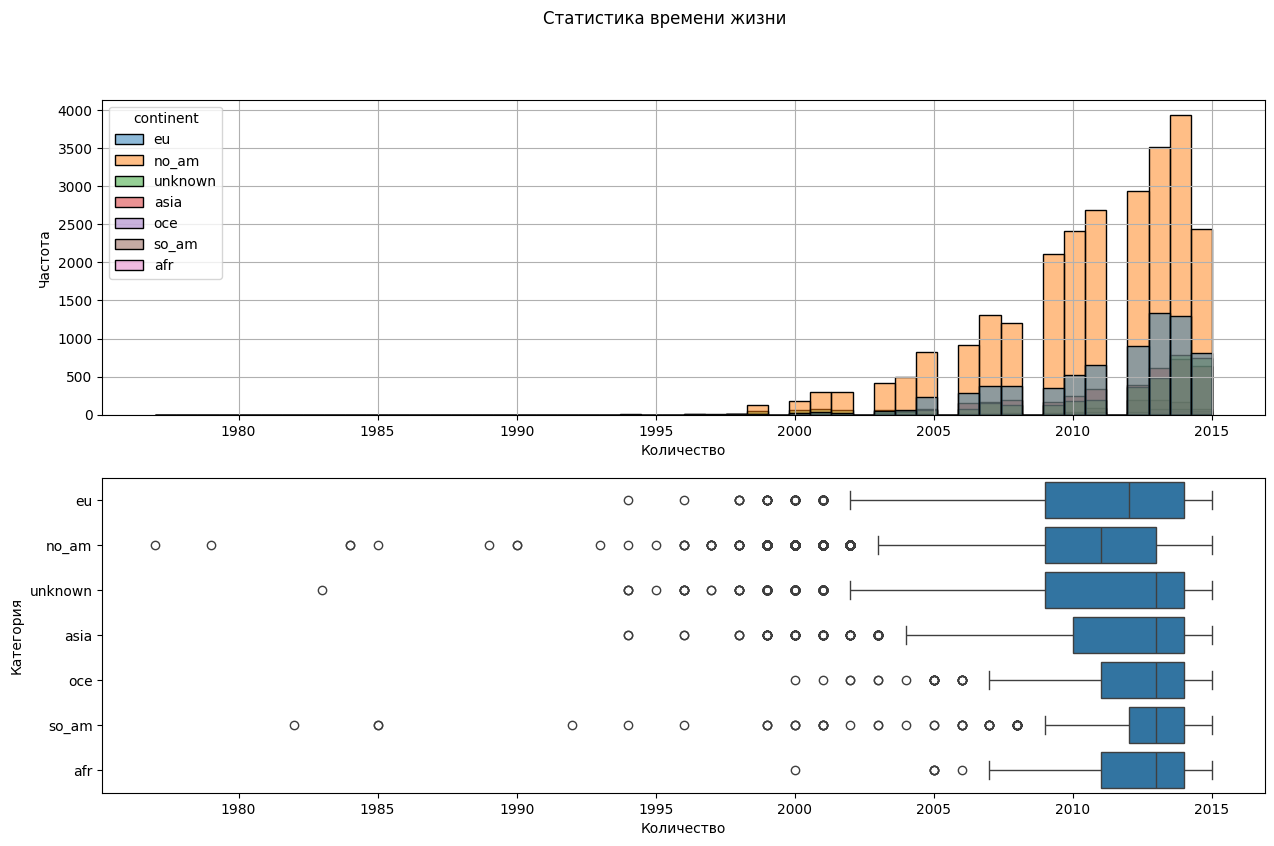

In [50]:
# данные о годе первой инвестиции
stat_chart(train_data,
            'first_funding_at_year',
            'Статистика годов  первой инвестиции',
            'Года', hue='continent')

**Вывод:**
1. Распределение одномодально асимметричное со смещением в право;


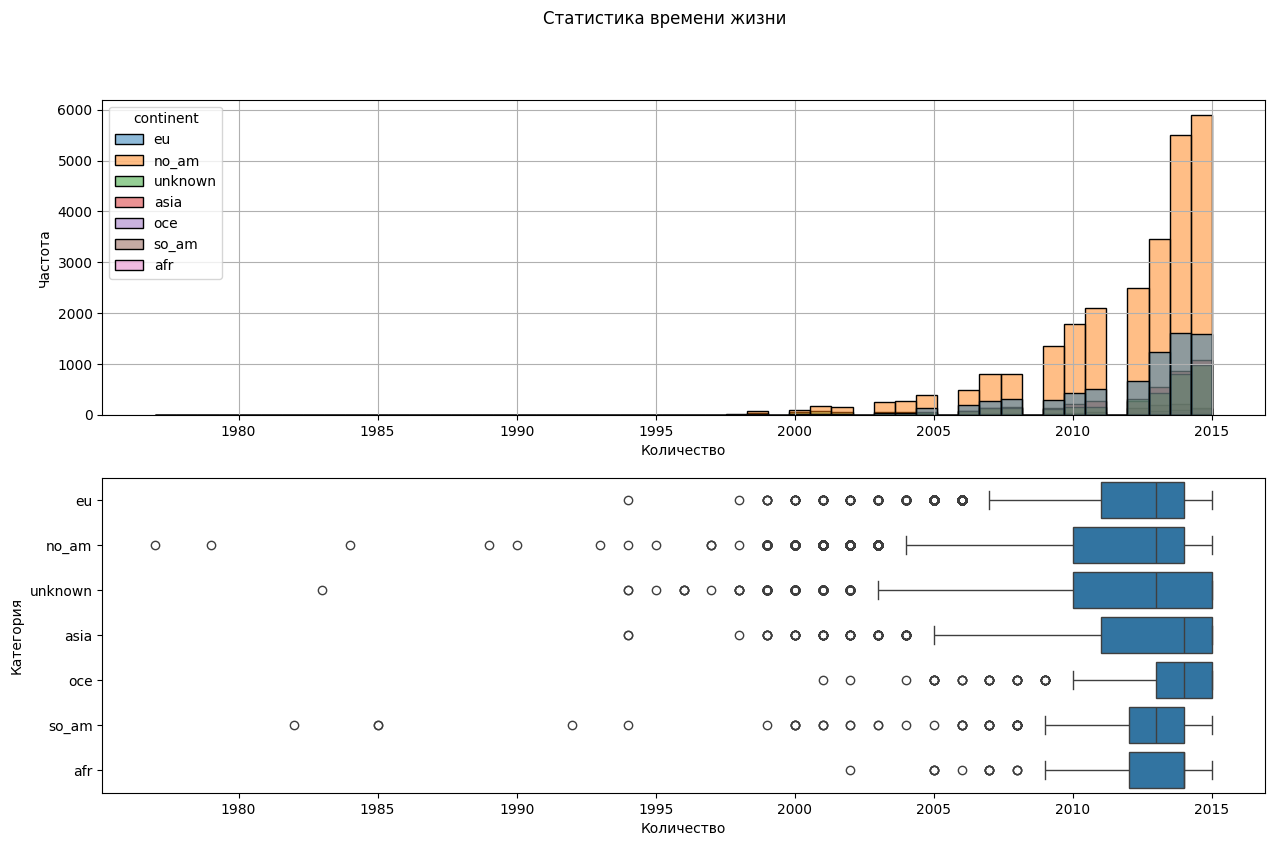

In [51]:
# данные о годе последней инвестиции

stat_chart(train_data,
            'last_funding_at_year',
            'Статистика времени жизни',
            'Количество', hue='continent')

**Вывод:**
1. Распределение одномодально асимметричное со смещением в право;


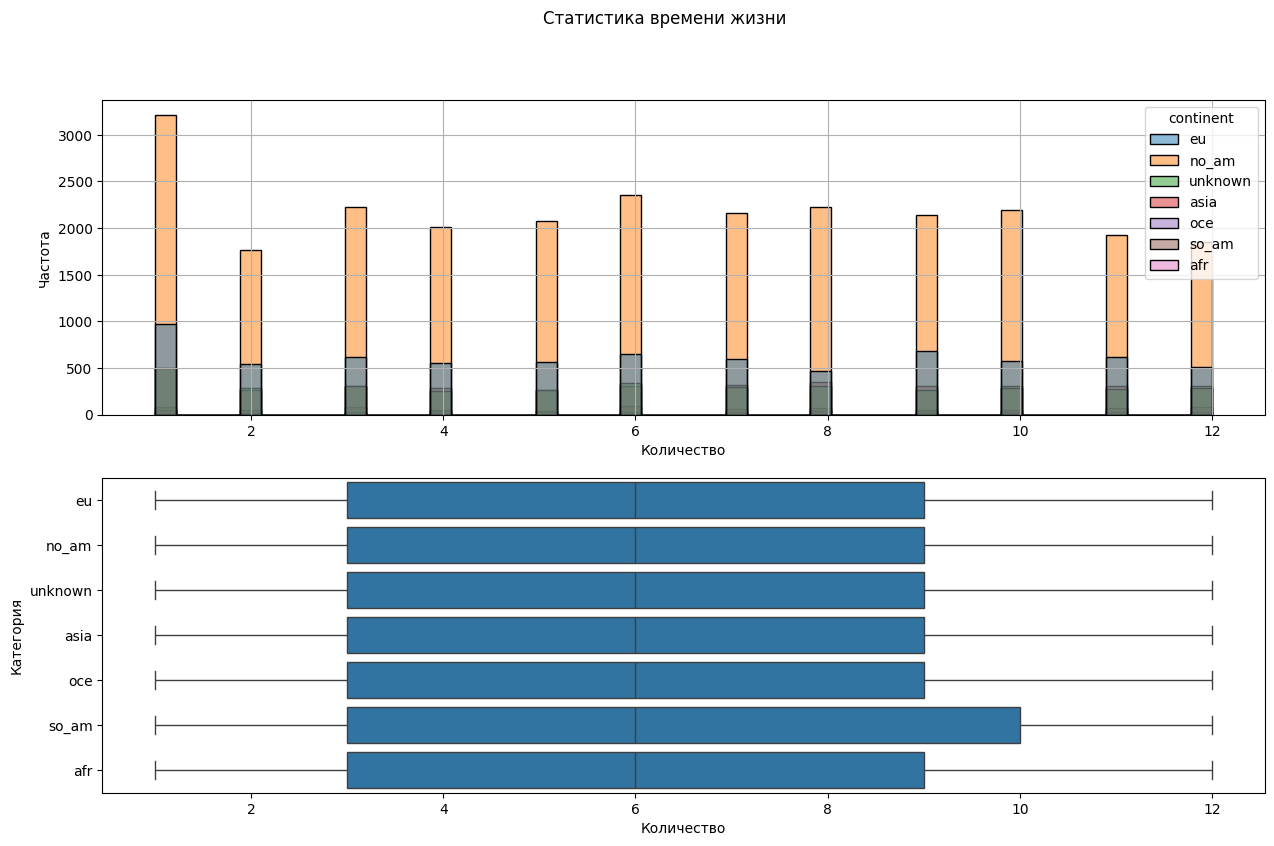

In [52]:
# данные о первых месяцев жизни

stat_chart(train_data,
            'first_funding_at_month',
            'Статистика по календарным месяцам первой инвестиции',
            'Номер месяца', hue='continent')

**Вывод:**
1. Распределение одномодальное асимметричное;
2. Мода - январь.

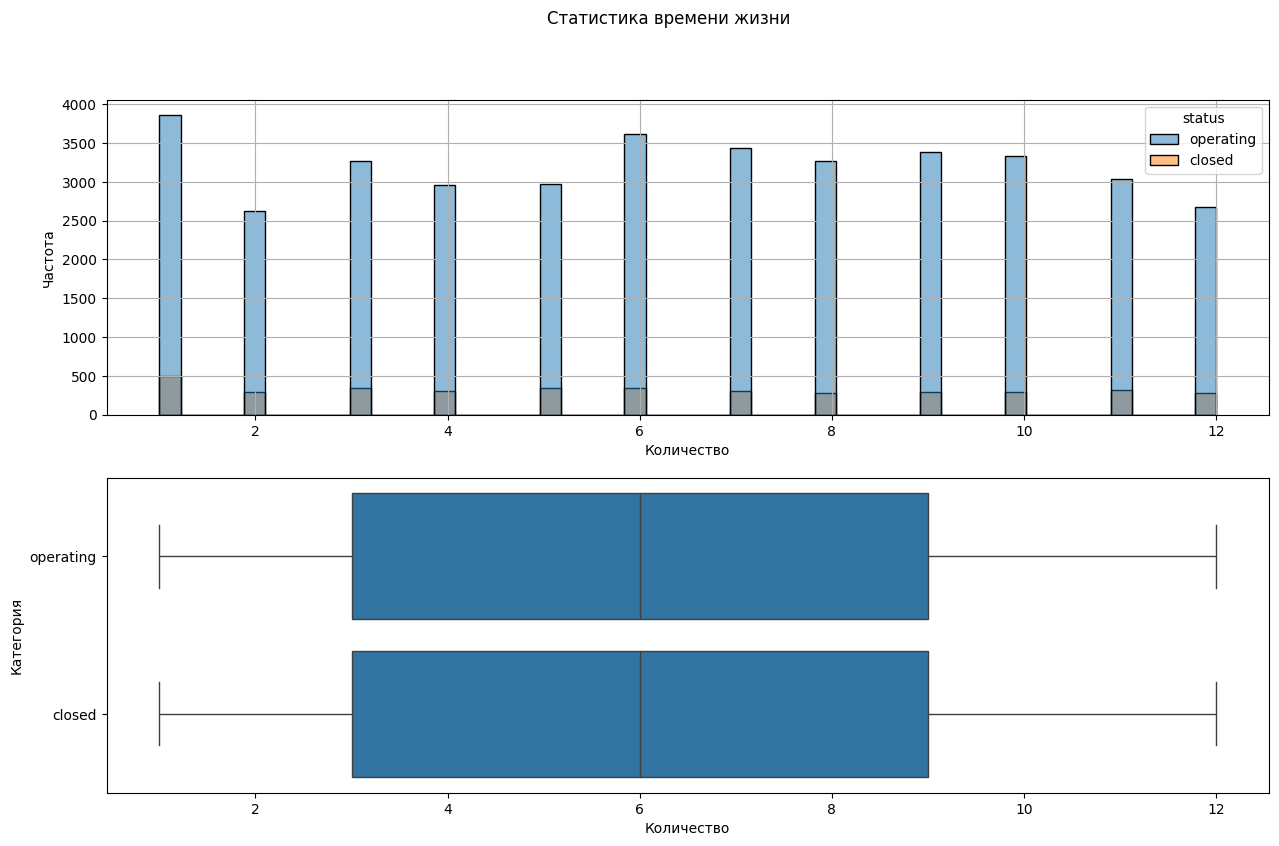

In [53]:
# данные о месяце последней инвестиции

stat_chart(train_data,
            'last_funding_at_month',
            'Статистика по месяцам послнедней инвестиции',
            'Количество', hue='status')

**Вывод:**
1. Распределение одномодальное асимметричное;
2. Мода - январь.

C:\Users\USER1\AppData\Roaming\Python\Python312\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


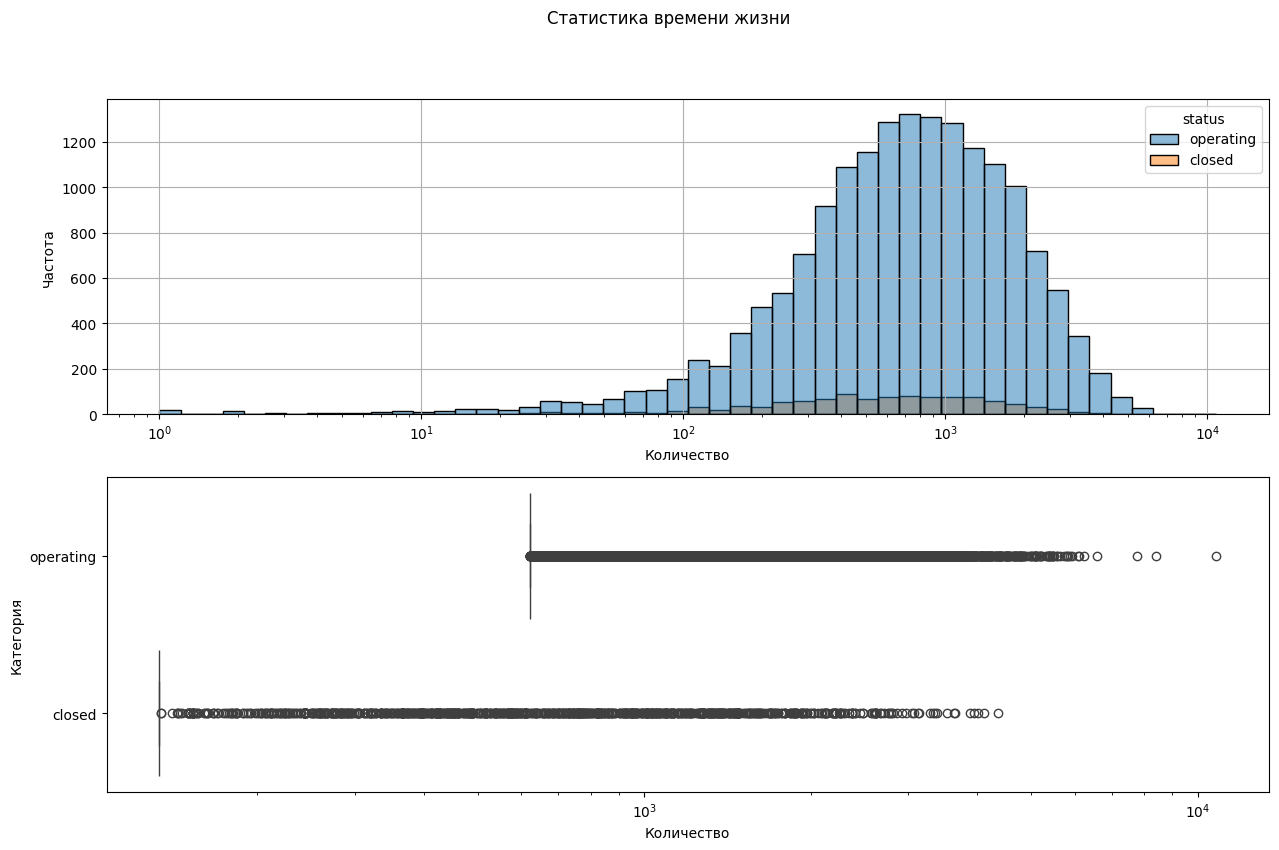

In [54]:
# данные о разнице во времени между первой и последней инвестиции

stat_chart(train_data,
            'time_bwn_funding',
            'Статистика времени жизни',
            'Количество', hue='status', log_scale=True)

In [55]:
#оставим только усеченное распределение
train_data = train_data.query('100 < time_bwn_funding')

**Вывод:**
1. По форме раcпределение похоже на лог нормальное;
2. Присутствуют выбросы, можно применить усеченное распределение.

In [6]:
# добавим дополнительный признак логарифм разницы во времени между новым и с последней инвестиций
train_data['log_time_bwn_funding'] = np.log10(train_data['time_bwn_funding'])

In [57]:
#т. к. общие инвестиции  имеют логнормальное распределение добавиим новый признак п
train_data['log_total_usd'] = np.log10(train_data['funding_total_usd'])

C:\Users\USER1\AppData\Local\Temp\ipykernel_17756\2762053676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['log_total_usd'] = np.log10(train_data['funding_total_usd'])


**Промежуточный вывод:** 
1. Распределение времени по 2 признакам  лог нормальное (суммарные инвестиции и время между первыми и последними инвестициями);
2. По этим же признакакам избавились от выбросов

#### Категориальные данные

Удалим признаки `name`, `category_list`, `country_code`, `state_code`, `region`, `city`, `first_funding_at`, `last_funding_at`,  т.к. в них очень много уникальных значений, что может усложнить обучение модели. Либо для их использования нужна их группировка.

In [58]:
train_data2 = train_data.drop(['name','category_list', 'country_code','state_code', 'region', 'city',
       'first_funding_at', 'last_funding_at'#, 
       #'category_list2',
       #'category_list3'
       ], axis=1)

In [59]:
cat_col_names = train_data2.select_dtypes(include='object').columns

In [60]:
train_data2.select_dtypes(include='object').columns

Index(['status', 'continent'], dtype='object')

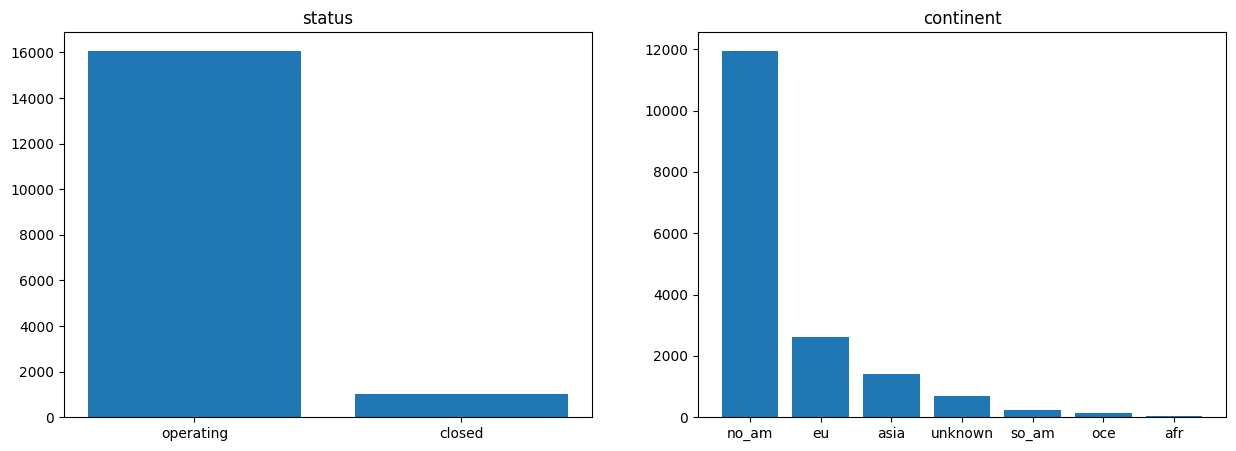

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for ax, col in zip(axs, train_data2[cat_col_names].columns.tolist()):
    ax.bar(train_data2[col].value_counts().index, train_data2[col].value_counts())
    ax.set_title(col)


plt.show()

**Вывод:**
1. Удалили часть категориальных признаков из-за наличия большого числа категориальных данных;
2. Построили распредедения по целевому признаку. Соотношение между значениями разнится на порядок. Ожидается чтоб будет проблема дисбаланса;
3. Простроили распределение по новому признаку "континенты" распределение не равномерное. Наибольшее количество стартапов в северной америке и наименьшее в африке.

### Корреляционный анализ

Для проведения корреклционного анализа воспользуемся функциями библиотеки `phik`

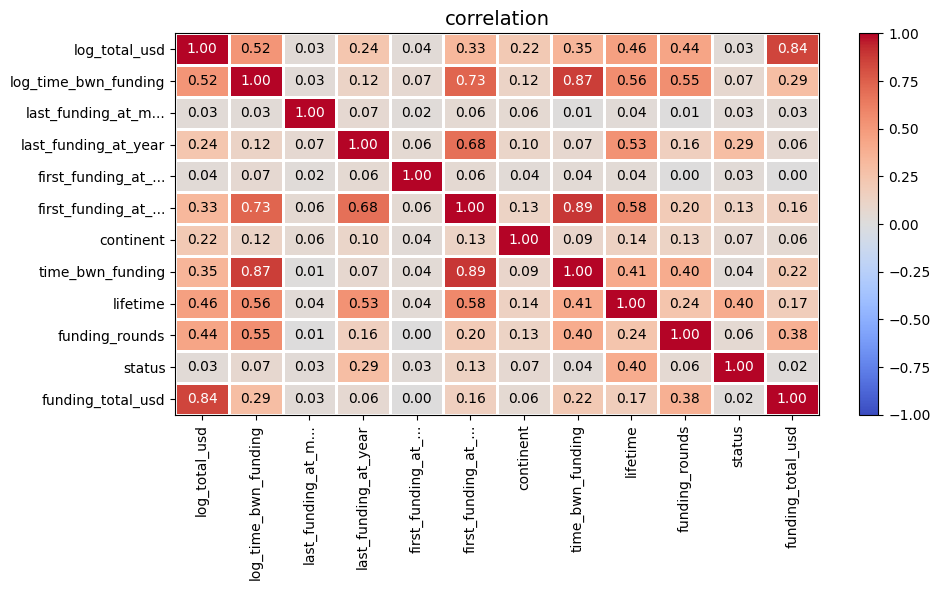

In [62]:
cm = train_data2.phik_matrix(interval_cols=[ 'funding_total_usd', 'funding_rounds', 'lifetime',
       'first_funding_at_year', 'first_funding_at_month',
       'last_funding_at_year', 'last_funding_at_month', 'time_bwn_funding',
       'log_time_bwn_funding', 'log_total_usd'])

plot_correlation_matrix(
    cm.values,
    x_labels=cm.columns,
    y_labels=cm.index,
    color_map='coolwarm',
    figsize=(10,6)
)

**Вывод:**
Есть значительная коллениарность между разницей дней последней и первой датами инвестиций. Остальные сильные зависимости только между новыми log признаками и их образующими.

In [64]:
num_col_names = train_data2.columns
num_col_names

Index(['funding_total_usd', 'status', 'funding_rounds', 'lifetime',
       'time_bwn_funding', 'continent', 'first_funding_at_year',
       'first_funding_at_month', 'last_funding_at_year',
       'last_funding_at_month', 'log_time_bwn_funding', 'log_total_usd'],
      dtype='object')

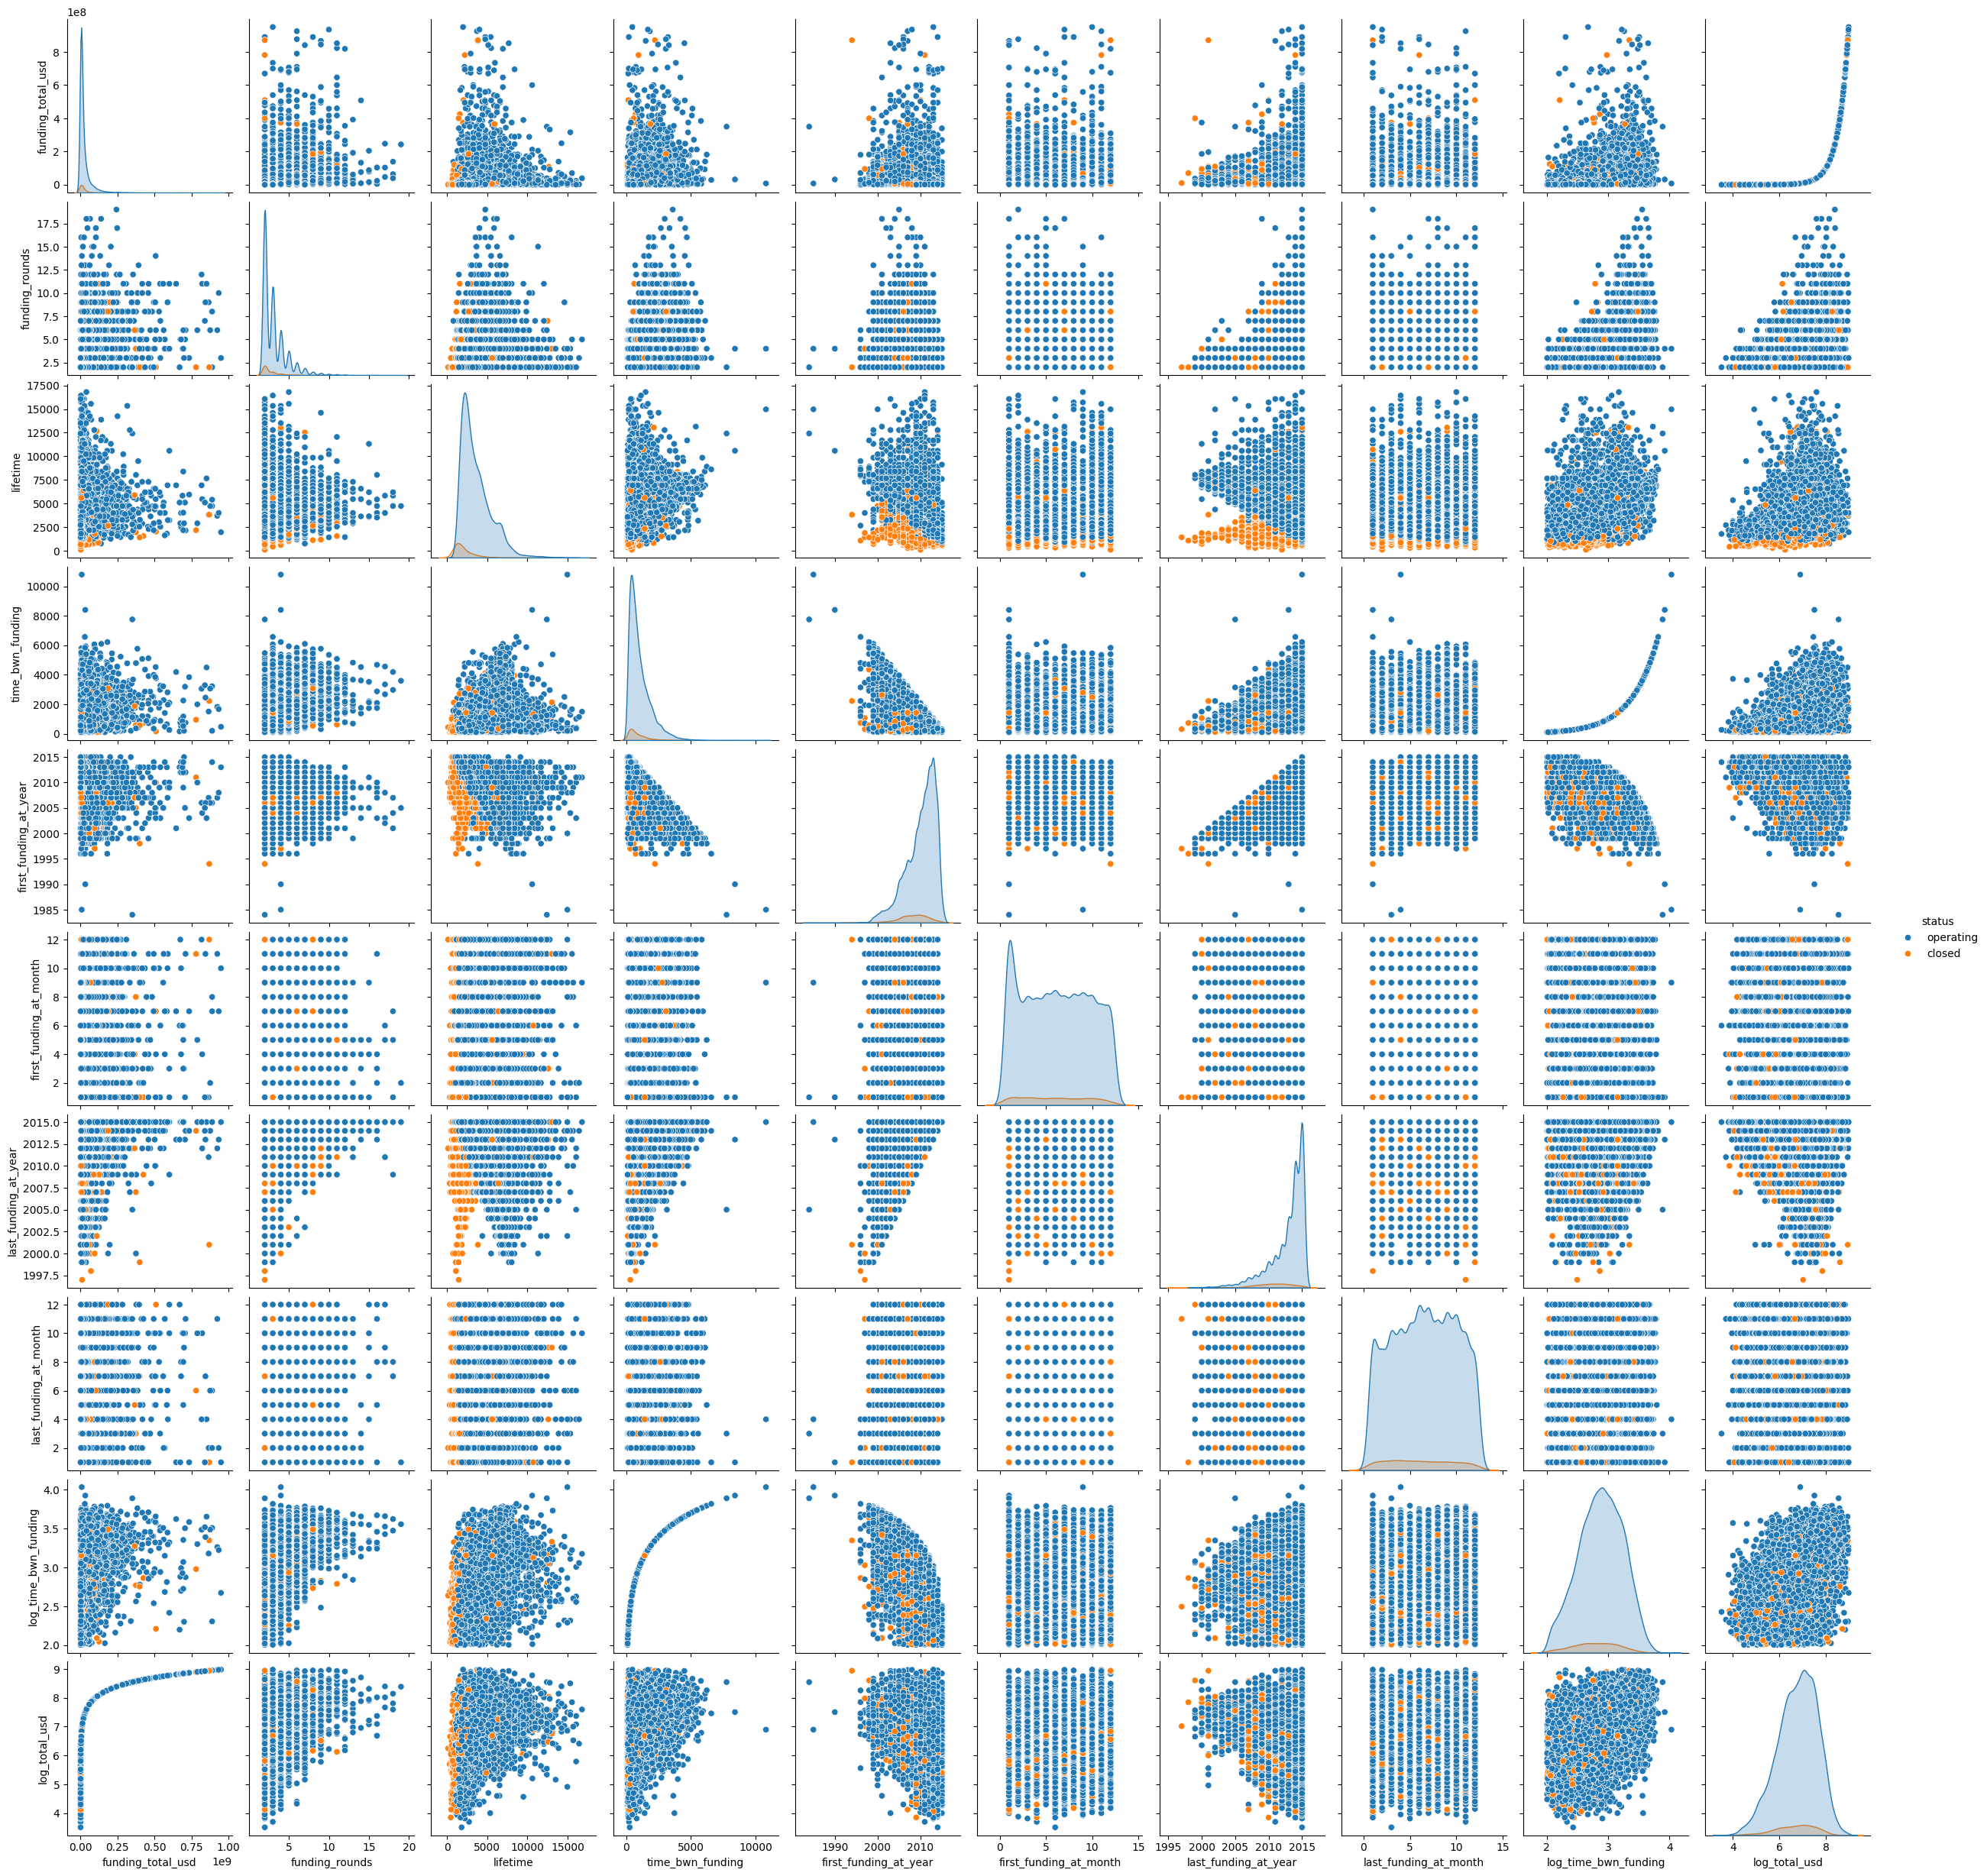

In [66]:
#построение графиков зависимости для количественных данных с группировкой по целевому признаку
sns.pairplot(train_data2[num_col_names], kind='scatter', markers='o', hue='status')
plt.show()

**Вывод:** Судя по графикам визуально не видна зависимость между всеми этими признаками.(синтетический признак) не учитываем

### Построение пайплайна

В данной задании будет решается задача классификации. Воспользуемся моделям:
- дерево решений;
- логистическая регрессия;
- метод K-соседей;
- градиентный бустинг (в данной работе применим catboost).

#### Обучающие данные

In [8]:
#разделим обучающую выборку на входные признаки и целевые
X_train = train_data2.drop('status', axis=1)
y_train = train_data2['status']

NameError: name 'train_data2' is not defined

In [69]:
#удалим признаки из которых образовали новые
X_train = X_train.drop(['time_bwn_funding', 'funding_total_usd'], axis=1)

In [9]:
#закодируем целевой признак 
y_encoder = LabelEncoder()
y_encoder.fit(['closed', 'operating'])

y_train_c = pd.DataFrame(y_encoder.transform(y_train))


NameError: name 'LabelEncoder' is not defined

In [72]:
#проведем оверсэмплинг, чтобы снизить проблему дисбаланса целевого признака
sampling = SMOTENC(categorical_features=['continent'])
X_train_samp, y_train_samp = sampling.fit_resample(X_train, y_train_c)

#### Тестовые данные

In [73]:
# добавили новый признак 'континенты' в тестовые данные
test_data = test_data.merge(continent, how='left', on='country_code')

In [74]:
# проверка на пропуски
test_data.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
continent            1382
dtype: int64

Пропуски только в категориальных данных. Количество пропусков в признаке `country_code` совпадает с пропусками в признаке `continent`.

In [75]:
# Заполнение пропусков значением `unknown`, т.к. не корректно их заполнять какими-то конкретными значениями.
test_data[['name', 'category_list', 'country_code',
       'state_code', 'region', 'city', 'continent']] = test_data[['name', 'category_list', 'country_code', 'state_code', 'region', 'city', 'continent']].fillna('unknown')

In [76]:
#Создание новых количественных признаков как в обучающей выборке.
test_data['log_total_usd'] = np.log10(test_data['funding_total_usd'])
test_data['time_bwn_funding'] = (test_data['last_funding_at'] - test_data['first_funding_at']).dt.days
test_data['log_time_bwn_funding'] = np.log10(test_data['time_bwn_funding'])

C:\Users\USER1\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [77]:
# т.к. имена не будут использованы в обучении используем их в качестве индекса
test_data = test_data.set_index('name')

In [78]:
# по аналогии  с обучающими данными добавляем новые признаки в тестовые данные
test_data = split_date(test_data, 'first_funding_at', 'last_funding_at')

In [79]:
#формируем входные данные для тестового предсказания
X_test = test_data.drop([ 'category_list', 'country_code',
       'state_code', 'region', 'city','first_funding_at', 'last_funding_at'], axis=1)

In [80]:
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(-9999)

#### Пайплайн предобработки

In [117]:
#выделим в отдельные списки категориальных и количественных столбцов
ohe_columns = ['continent']
num_col_names = X_test.drop(['funding_total_usd','time_bwn_funding'], axis=1).select_dtypes(exclude='object').columns

In [119]:
#пайплайн обработки категориальных данных. Т.к. значения номинальные и уникальных значений немного воспользуемся OneHotEncoder
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan,
                         strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first',sparse_output=False, handle_unknown='ignore')
        )
    ]
)
# объеденим в один пайплайн масштабирование и кодирование
data_preprocessor = ColumnTransformer(
    [
  
        ('ohe', ohe_pipe, ohe_columns),
        
        ('num', StandardScaler(), num_col_names),
        
    ],
    remainder='passthrough'
)

# итоговый пайплайн с подготовкой данных и моделью
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        #('models', CatBoostClassifier(iterations=1000, l2_leaf_reg=5, depth=10, learning_rate= 0.02, cat_features=['continent']))
        ('models', LogisticRegression(random_state=RANDOM_STATE, solver='saga', penalty='elasticnet', l1_ratio=0.8))
    ]
)


#### Гиперпараметры

In [99]:
#Создание словарая по перебору простых гиперпараметров простых моделей
param_dist = [
    {
        #Словарь для DecisionTreeClassifier
        'models' : [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split' : range(2,10),
        'models__min_samples_leaf' : range(2,10),
        'models__max_depth' : range(2,10),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']        
    }, 
    {
        #Словарь для KNeigborsClassifier
        'models' : [KNeighborsClassifier()],
        'models__n_neighbors' : range(1,20),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']        
    },
    
    {
        #Словарь для LogisticRegression
        'models' : [LogisticRegression(random_state=RANDOM_STATE, solver='saga', penalty='elasticnet')],
        'models__C' : range(1,5),
        'models__l1_ratio' : np.linspace(0.1, 1, 10).tolist(),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']       
    }
]

In [121]:
rand_model = RandomizedSearchCV(pipe_final,
                                param_distributions=param_dist,
                                cv=5,
                                scoring='f1',
                                n_jobs=-1,
                                random_state=RANDOM_STATE,
                                n_iter=2000
                                )

#### Подбор лучших гиперпараметров простых моделей

In [122]:
start = time.time()
#запуск поиска
rand_model.fit(X_train_samp, y_train_samp)

search_time = time.time() - start
print('Лучшая модель и её параметры: \n\n', rand_model.best_estimator_)
print('Метрика лучшей модели на кросс-валидационной выборке: \n\n', rand_model.best_score_)

print(f'Время расчёта: {search_time:.0f} сек')

Лучшая модель и её параметры: 

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['continent']),
                                                 ('num', 'passthrough',
                                                  Index(['funding_rounds', 'lifetime', 'log_total_usd

C:\Users\USER1\AppData\Roaming\Python\Python312\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### Обработка результата подбора простой модели

In [ ]:
X_test['predict2'] = rand_model.predict(X_test)
X_test['predict2'] = y_encoder.inverse_transform(X_test['predict2'])
X_test['predict2'].to_csv('kaggle_startups_test_28062024(simple).csv')

**Вывод:** Получили что  на обучающей выборке результат 0.97, на тестовой выборке получен результат 0.21. Это свидетельсвтует, что полученная модель слишком переобучена. Модель не справилась с задачей. 
Наилучшей моделью оказалась модель ближайших соседей. НО число соседних = 1 при условии что применился также метод без кодирования то это не удивительно, т.к. видимо соседние значения слишко разнообразные. 
Для дальнейшего исследования необходимо:
- ввести новые признаки;
- скорреткировать диапазон гиперпараметров и пересчитать.

Следующим шагом попробуем модель бустинга.

### Модель Catboost

#### Создание пайплайна и подбор гиперпараметров для catboost

In [195]:
##Базовая модель
# объеденим в один пайплайн масштабирование и кодирование
data_preprocessor2 = ColumnTransformer(
    [
  
        ('ohe', ohe_pipe, ohe_columns),
        
        ('num', StandardScaler(), num_col_names)
        
    ],
    remainder='passthrough'
)
pipe_final2 = Pipeline(
    [
        ('preprocessor', data_preprocessor2),
        ('models', CatBoostClassifier(iterations=1000, l2_leaf_reg=5, depth=10, learning_rate= 0.02, loss_function='CrossEntropy', objective='Logloss'))
        
    ]
)

In [208]:
#Создание словаря для перебора гипер параметров.
# будем изменять регуляризацию листов, порог прироста метрики, глубину деревьев
param_dist3 = {                
                'models__l2_leaf_reg' : range(5,10),
                'models__learning_rate' : [0.1, 0.2, 0.3, 0.4, 0.5],
                'models__depth' : range(4,10),
                'preprocessor__num' : [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
                }
    

In [15]:
# Сформировали перебор гипер параметров.
grid_boost = GridSearchCV(pipe_final2,
                          param_grid=param_dist3,
                          cv=5,
                          scoring='f1',
                          n_jobs=-1
                         )

IndentationError: unindent does not match any outer indentation level (<string>, line 6)

In [210]:
#перебор гиперпараметров
grid_boost.fit(X_train_samp, y_train_samp)

0:	learn: 0.4553125	total: 48.6ms	remaining: 48.5s
1:	learn: 0.3290262	total: 95.4ms	remaining: 47.6s
2:	learn: 0.2714012	total: 139ms	remaining: 46.3s
3:	learn: 0.2393162	total: 188ms	remaining: 46.8s
4:	learn: 0.2122094	total: 235ms	remaining: 46.8s
5:	learn: 0.1953659	total: 287ms	remaining: 47.5s
6:	learn: 0.1826217	total: 337ms	remaining: 47.9s
7:	learn: 0.1734992	total: 394ms	remaining: 48.9s
8:	learn: 0.1648460	total: 449ms	remaining: 49.5s
9:	learn: 0.1602896	total: 500ms	remaining: 49.5s
10:	learn: 0.1553324	total: 547ms	remaining: 49.2s
11:	learn: 0.1502225	total: 593ms	remaining: 48.8s
12:	learn: 0.1459820	total: 637ms	remaining: 48.4s
13:	learn: 0.1420777	total: 683ms	remaining: 48.1s
14:	learn: 0.1385076	total: 736ms	remaining: 48.3s
15:	learn: 0.1343869	total: 795ms	remaining: 48.9s
16:	learn: 0.1311823	total: 846ms	remaining: 48.9s
17:	learn: 0.1292853	total: 891ms	remaining: 48.6s
18:	learn: 0.1261952	total: 937ms	remaining: 48.4s
19:	learn: 0.1234808	total: 985ms	remai

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['continent']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         Index(['funding_rounds', 'lif...
       'last_funding_at_year', 'last_funding_at_month'],
      dtype='object'))])),
                                       ('models',
                                        <catboost.core.CatBoostClassifier object at 0x00000298B19B2390>)]),
             n_jobs=-1,
             param_grid={'models__depth': range(4, 10),
                         'models__l2_leaf_reg': range(5, 10),
                         'models__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'preprocessor__num': [StandardScaler(), MinMaxScaler(),
                                               RobustScaler(), 'passthrough']},
             scoring='f1')

In [211]:
print('Лучшая модель и её параметры: \n\n', grid_boost.best_estimator_)
print('Метрика лучшей модели на кросс-валидационной выборке: \n\n', grid_boost.best_score_)

Лучшая модель и её параметры: 

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['continent']),
                                                 ('num', 'passthrough',
                                                  Index(['funding_rounds', 'lifetime', 'log_total_usd

In [212]:
#лучшие гиперпараметры
grid_boost.best_params_

{'models__depth': 9,
 'models__l2_leaf_reg': 5,
 'models__learning_rate': 0.2,
 'preprocessor__num': 'passthrough'}

In [ ]:
#Сформировали выгрузку

X_test['predict2'] = grid_boost.predict(X_test)
X_test['predict2'] = y_encoder.inverse_transform(X_test['predict2'])
X_test['predict2'].to_csv('kaggle_startups_test(catboost_grid).csv')

**Вывод:** по резульатату на обучающей выборки получено значение 0.98, на тестовой 0.82. Модель catboost справилась с задачей.

### Оценка важности лучшей модели

Для оценки важности модели воспользуемся методикой оценки SHAP.

In [226]:
X_train_new = grid_boost.best_estimator_[0].transform(X_train_samp)
X_train_new

array([[0.000e+00, 1.000e+00, 0.000e+00, ..., 5.000e+00, 2.014e+03,
        1.200e+01],
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 5.000e+00, 2.014e+03,
        2.000e+00],
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 8.000e+00, 2.014e+03,
        7.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 7.000e+00, 2.012e+03,
        8.000e+00],
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 2.000e+00, 2.009e+03,
        1.000e+00],
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 1.000e+00, 2.010e+03,
        1.000e+00]])

In [216]:
grid_boost.best_estimator_.predict_proba(X_train_new)

In [234]:
explainer = shap.Explainer(grid_boost.best_estimator_[1].predict_proba, X_train_new,
                           feature_names=grid_boost.best_estimator_[0].get_feature_names_out())

In [237]:
shap_values = explainer(X_train_new)

PermutationExplainer explainer: 32163it [2:33:47,  3.48it/s]                             


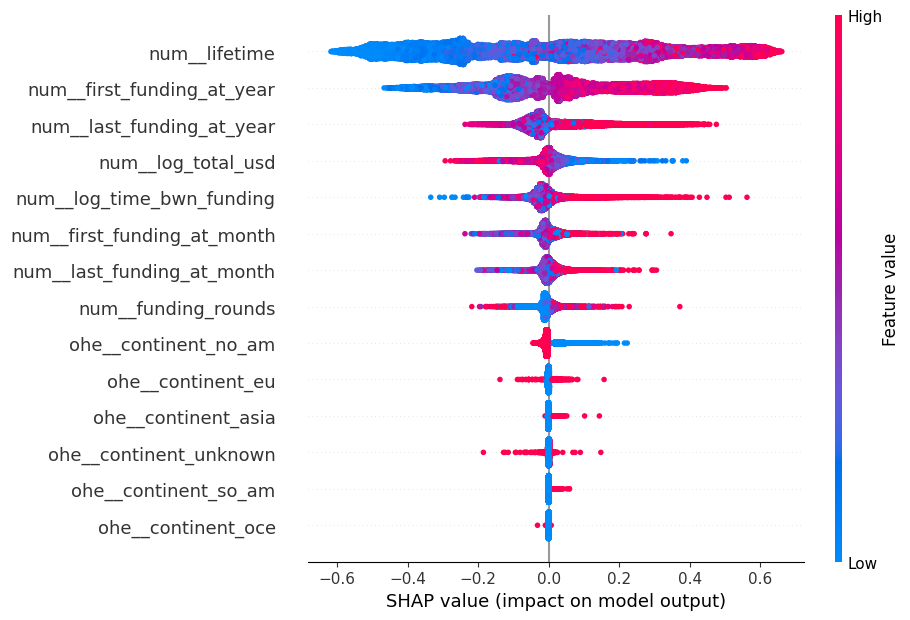

In [238]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=28)

**Вывод:** Согласно графику наиболее значимые параметры:
1. продолжительность жизни проекта;
2. год первой инвестиции;
3. количество вложений;

Пропустим год послежней инвестиции, т.к. согласно графику он действует не однозначно. Действительно год последней инвестиции есть всегда и в случае действующего стартапа и в случае закрытого стартапа, но во первом случае он может быть более поздним. и зависит от стадии развтития стартапа.

Согласно этому графику действующий стартапы и на которые следует обратить внимание например для инвестиций это те стратапы, которые:
- Имеют большее время жизни (это показатель, того что стартап является значимым и менее вероятно что закроется);
- имеют меньшее финансирование (наиболее);
- год запуска более поздний

